Color Information
{'cluster_index': 4,
 'color': [165.63683818045945, 97.09563758389208, 81.9546979865791],
 'color_percentage': 0.29975013881177126}

{'cluster_index': 2,
 'color': [144.2269639268952, 80.45383216916855, 69.35384173763347],
 'color_percentage': 0.2878956135480289}

{'cluster_index': 3,
 'color': [177.90949302483887, 123.85539299081117, 108.12470227968788],
 'color_percentage': 0.1641588006662965}

{'cluster_index': 1,
 'color': [116.11789562645224, 56.146207479400076, 47.651595182759394],
 'color_percentage': 0.1308717379233759}

{'cluster_index': 0,
 'color': [144.03687943262412, 98.19078014184282, 92.80709219858238],
 'color_percentage': 0.11732370905052748}

Color Bar


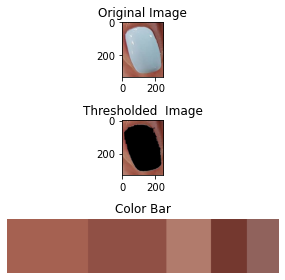

In [1]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt


def extractSkin(image):
    # Taking a copy of the image
    img = image.copy()
    # Converting from BGR Colours Space to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Defining HSV Threadholds
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)


def removeBlack(estimator_labels, estimator_cluster):

    # Check for black
    hasBlack = False

    # Get the total number of occurance for each color
    occurance_counter = Counter(estimator_labels)

    # Quick lambda function to compare to lists
    def compare(x, y): return Counter(x) == Counter(y)

    # Loop through the most common occuring color
    for x in occurance_counter.most_common(len(estimator_cluster)):

        # Quick List comprehension to convert each of RBG Numbers to int
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]

        # Check if the color is [0,0,0] that if it is black
        if compare(color, [0, 0, 0]) == True:
            # delete the occurance
            del occurance_counter[x[0]]
            # remove the cluster
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break

    return (occurance_counter, estimator_cluster, hasBlack)


def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):

    # Variable to keep count of the occurance of each color predicted
    occurance_counter = None

    # Output list variable to return
    colorInformation = []

    # Check for Black
    hasBlack = False

    # If a mask has be applied, remove th black
    if hasThresholding == True:

        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurance_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurances
    totalOccurance = sum(occurance_counter.values())

    # Loop through all the predicted colors
    for x in occurance_counter.most_common(len(estimator_cluster)):

        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage = (x[1]/totalOccurance)

        # make the dictionay of the information
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}

        # Add the dictionary to the list
        colorInformation.append(colorInfo)

    return colorInformation


def extractDominantColor(image, number_of_colors=5, hasThresholding=False):

    # Quick Fix Increase cluster counter to neglect the black(Read Article)
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0]*img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation


def plotColorBar(colorInformation):
    # Create a 500x100 black image
    color_bar = np.zeros((100, 500, 3), dtype="uint8")

    top_x = 0
    for x in colorInformation:
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

        color = tuple(map(int, (x['color'])))

        cv2.rectangle(color_bar, (int(top_x), 0),
                      (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x
    return color_bar


"""## Section Two.4.2 : Putting it All together: Pretty Print
The function makes print out the color information in a readable manner
"""


def prety_print_data(color_info):
    for x in color_info:
        print(pprint.pformat(x))
        print()


"""
The below lines of code, is the implementation of the above defined function.
"""

'''
Skin Image Primary : https://raw.githubusercontent.com/octalpixel/Skin-Extraction-from-Image-and-Finding-Dominant-Color/master/82764696-open-palm-hand-gesture-of-male-hand_image_from_123rf.com.jpg
Skin Image One     : https://raw.githubusercontent.com/octalpixel/Skin-Extraction-from-Image-and-Finding-Dominant-Color/master/skin.jpg
Skin Image Two     : https://raw.githubusercontent.com/octalpixel/Skin-Extraction-from-Image-and-Finding-Dominant-Color/master/skin_2.jpg
Skin Image Three   : https://raw.githubusercontent.com/octalpixel/Skin-Extraction-from-Image-and-Finding-Dominant-Color/master/Human-Hands-Front-Back-Image-From-Wikipedia.jpg
'''


# Get Image from URL. If you want to upload an image file and use that comment the below code and replace with  image=cv2.imread("FILE_NAME")
image = cv2.imread("./img/233.jpg")
   

# Resize image to a width of 250
image = imutils.resize(image, width=250)

# Show image
plt.subplot(3, 1, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
# plt.show()

# Apply Skin Mask
skin = extractSkin(image)

plt.subplot(3, 1, 2)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.title("Thresholded  Image")
# plt.show()

# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
dominantColors = extractDominantColor(skin, hasThresholding=True)

# Show in the dominant color information
print("Color Information")
prety_print_data(dominantColors)

# Show in the dominant color as bar
print("Color Bar")
colour_bar = plotColorBar(dominantColors)
plt.subplot(3, 1, 3)
plt.axis("off")
plt.imshow(colour_bar)
plt.title("Color Bar")

plt.tight_layout()
plt.show()

In [22]:
r = dominantColors[1]['color'][0]
g = dominantColors[1]['color'][1]
b = dominantColors[1]['color'][2]
r1 = dominantColors[2]['color'][0]
g1 = dominantColors[2]['color'][1]
b1 = dominantColors[2]['color'][2]


In [23]:
r,g,b

(207.83601799448928, 147.95080539834464, 132.5536206646351)

In [25]:
import cv2
import numpy as np

img = cv2.imread("img/362.jpg")
cv2.imshow('Original', img)

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

lower = np.array([r, g, b])
upper = np.array([r1, g1, b1])

mask = cv2.inRange(hsv, lower, upper)
img2 = cv2.bitwise_and(img, img, mask=mask)

cv2.imshow('Extract Color', img2)

k = cv2.waitKey(0)
cv2.destroyAllWindows()

In [26]:
handSkin = skin.copy()
cv2.imshow('handSkin', handSkin)
k = cv2.waitKey(0)
cv2.destroyAllWindows

<function destroyAllWindows>

In [27]:
dominantColors[1]['color'][1]

147.95080539834464

In [28]:
len(dominantColors)

5

In [2]:
lowColor = []
for i in dominantColors:
    print(i['color'][0])
    lowColor.append(i['color'][0])

165.63683818045945
144.2269639268952
177.90949302483887
116.11789562645224
144.03687943262412


In [3]:
lowColor2 = []
for i in dominantColors:
    print(i['color'][1])
    lowColor2.append(i['color'][1])

97.09563758389208
80.45383216916855
123.85539299081117
56.146207479400076
98.19078014184282


In [4]:
lowColor3 = []
for i in dominantColors:
    print(i['color'][2])
    lowColor3.append(i['color'][2])

81.9546979865791
69.35384173763347
108.12470227968788
47.651595182759394
92.80709219858238


In [5]:
lowColor3.sort()

In [6]:
lowColor2.sort()

In [7]:
lowColor.sort()

In [35]:
lowColor2[0]

108.337775499743

In [36]:
lowColor[-1]

229.79764107308344

In [10]:
import cv2
import numpy as np

img = cv2.imread("img/233.jpg")
cv2.imshow('Original', img)

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

lower = np.array([lowColor[0], lowColor2[0], lowColor3[0]])
upper = np.array([lowColor[-1], lowColor2[-1], lowColor3[-1]])

mask = cv2.inRange(hsv, lower, upper)
img2 = cv2.bitwise_and(img, img, mask=mask)

cv2.imshow('Extract Color', img2)

k = cv2.waitKey(0)
cv2.destroyAllWindows()

In [39]:
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
th, dst = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print("otsu's threshold:", th)  # 131

cv2.imshow('src', img2)
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()

otsu's threshold: 0.0
